In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from scipy import stats
from statsmodels.stats.diagnostic import het_breuschpagan

df = pd.read_csv('./source/d_full_clean.csv') # Load the original dataset
features = ['target_material','target_thickness','pulse_width','energy','spot_size','intensity','power','cutoff_energy']
numeric_features = features[1:]
df[numeric_features] = df[numeric_features].astype(float)

# Inspect head
df.head()

,target_material,target_thickness,pulse_width,energy,spot_size,intensity,power,cutoff_energy
0,plastic,0.562,30.0,2.393,3.3,6.467000e+20,7.976000e+13,0.0
1,plastic,0.000,30.0,2.380,3.3,6.432000e+20,7.933000e+13,0.0
2,plastic,0.534,30.0,2.416,3.3,6.529000e+20,8.052000e+13,0.0
3,plastic,0.556,30.0,2.459,3.3,6.645000e+20,8.196000e+13,0.0
4,plastic,0.770,30.0,2.410,3.3,6.514000e+20,8.033000e+13,0.0


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1093 entries, 0 to 1092
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   target_material   1093 non-null   object 
 1   target_thickness  1093 non-null   float64
 2   pulse_width       1093 non-null   float64
 3   energy            1093 non-null   float64
 4   spot_size         1093 non-null   float64
 5   intensity         1093 non-null   float64
 6   power             1093 non-null   float64
 7   cutoff_energy     1093 non-null   float64
dtypes: float64(7), object(1)
memory usage: 68.4+ KB


In [3]:
df.describe()

,target_thickness,pulse_width,energy,spot_size,intensity,power,cutoff_energy
count,1093.000000,1093.000000,1093.000000,1093.000000,1.093000e+03,1.093000e+03,1093.000000
mean,1.321934,419.921317,23.789886,4.151524,5.046107e+20,6.611677e+13,8.785178
std,5.300478,3226.979346,131.067934,6.796773,6.243160e+20,7.888699e+13,12.684160
min,0.000000,24.000000,0.302000,2.127000,1.053000e+18,1.758000e+11,0.000000
25%,0.494000,30.000000,2.311000,3.300000,6.820000e+19,8.457000e+12,4.400000
50%,0.595000,30.000000,2.355000,3.300000,6.216000e+20,7.684000e+13,4.800000
75%,0.775000,279.000000,2.414000,3.300000,6.436000e+20,7.962000e+13,6.200000
max,125.000000,99700.000000,2600.000000,100.000000,5.589000e+21,1.000000e+15,95.000000


In [4]:
df.isna().sum()

target_material     0
target_thickness    0
pulse_width         0
energy              0
spot_size           0
intensity           0
power               0
cutoff_energy       0
dtype: int64

In [5]:
# Inspecting unique categorical values in target_material column
df['target_material'].unique()

array(['plastic', 'copper', 'polystyrene', 'titanium', 'gold',
       'aluminium', 'ch', 'polypropylene', 'cvd'], dtype=object)

In [6]:
# Categorical counts, Plastik is most fequent target_material followed by Gold and Polystyrol.
target_material_counts = df.groupby('target_material').count().iloc[:,0].sort_values(ascending=False)
target_material_counts

target_material
plastic          960
gold              62
polystyrene       38
aluminium         11
polypropylene      9
copper             5
ch                 4
titanium           3
cvd                1
Name: target_thickness, dtype: int64

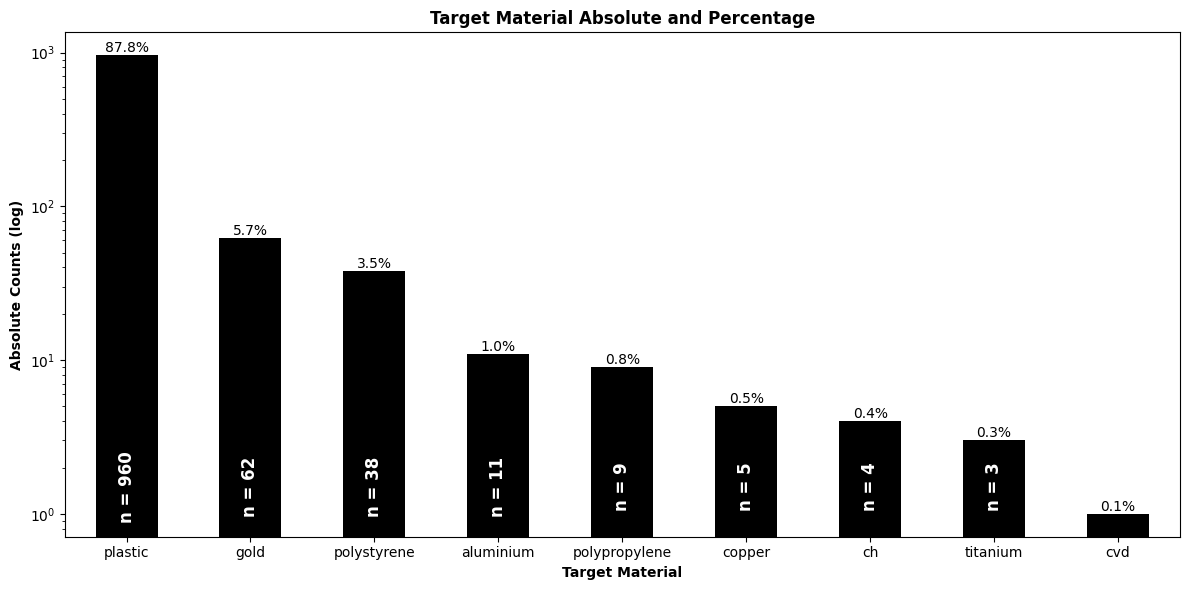

In [7]:
# Calculate the normalized values
total = target_material_counts.sum()
target_material_normalized_count = (target_material_counts / total) * 100

# Create a bar plot for absolute counts
fig, ax1 = plt.subplots(figsize=(12, 6))
bars = target_material_counts.plot(kind='bar', ax=ax1, color='black', label='Absolute Counts')

# Set labels and title
ax1.set_title('Target Material Absolute and Percentage', fontweight='bold')
ax1.set_ylabel('Absolute Counts (log)', fontweight='bold')
ax1.set_xlabel('Target Material', fontweight='bold')

# Switch to log scale on y-axis
ax1.set_yscale('log')

# Rotate x-axis labels to horizontal (0 degrees)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0, ha='center')

# Add text annotations for percentages at the top of each bar and counts inside the bar
for bar, percentage, label in zip(bars.patches, target_material_normalized_count, target_material_counts.index):
    height = bar.get_height()
    # Text for the percentage on top of the bar
    ax1.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{percentage:.1f}%',
        ha='center',
        va='bottom',
        color='black',
    )
    # Determine y-position for the count text based on specific condition
    y_pos = 1.5 if label != 'cvd' else height + 1  # Adjust the 'cvd' label to be above the bar if the count is 1
    # Text for the count inside the bar, rotated to be vertical and centered
    ax1.text(
        bar.get_x() + bar.get_width() / 2,
        y_pos,
        f'n = {int(height)}',
        ha='center',
        va='center',
        color='white',  # White text color
        fontsize=12,  # Adjust the font size if needed
        rotation='vertical',  # Rotate text to vertical
        weight='bold'
    )

# Adjust layout to ensure proper spacing
plt.tight_layout()
plt.savefig('eda_target_material_frequencies.jpg')
plt.show()


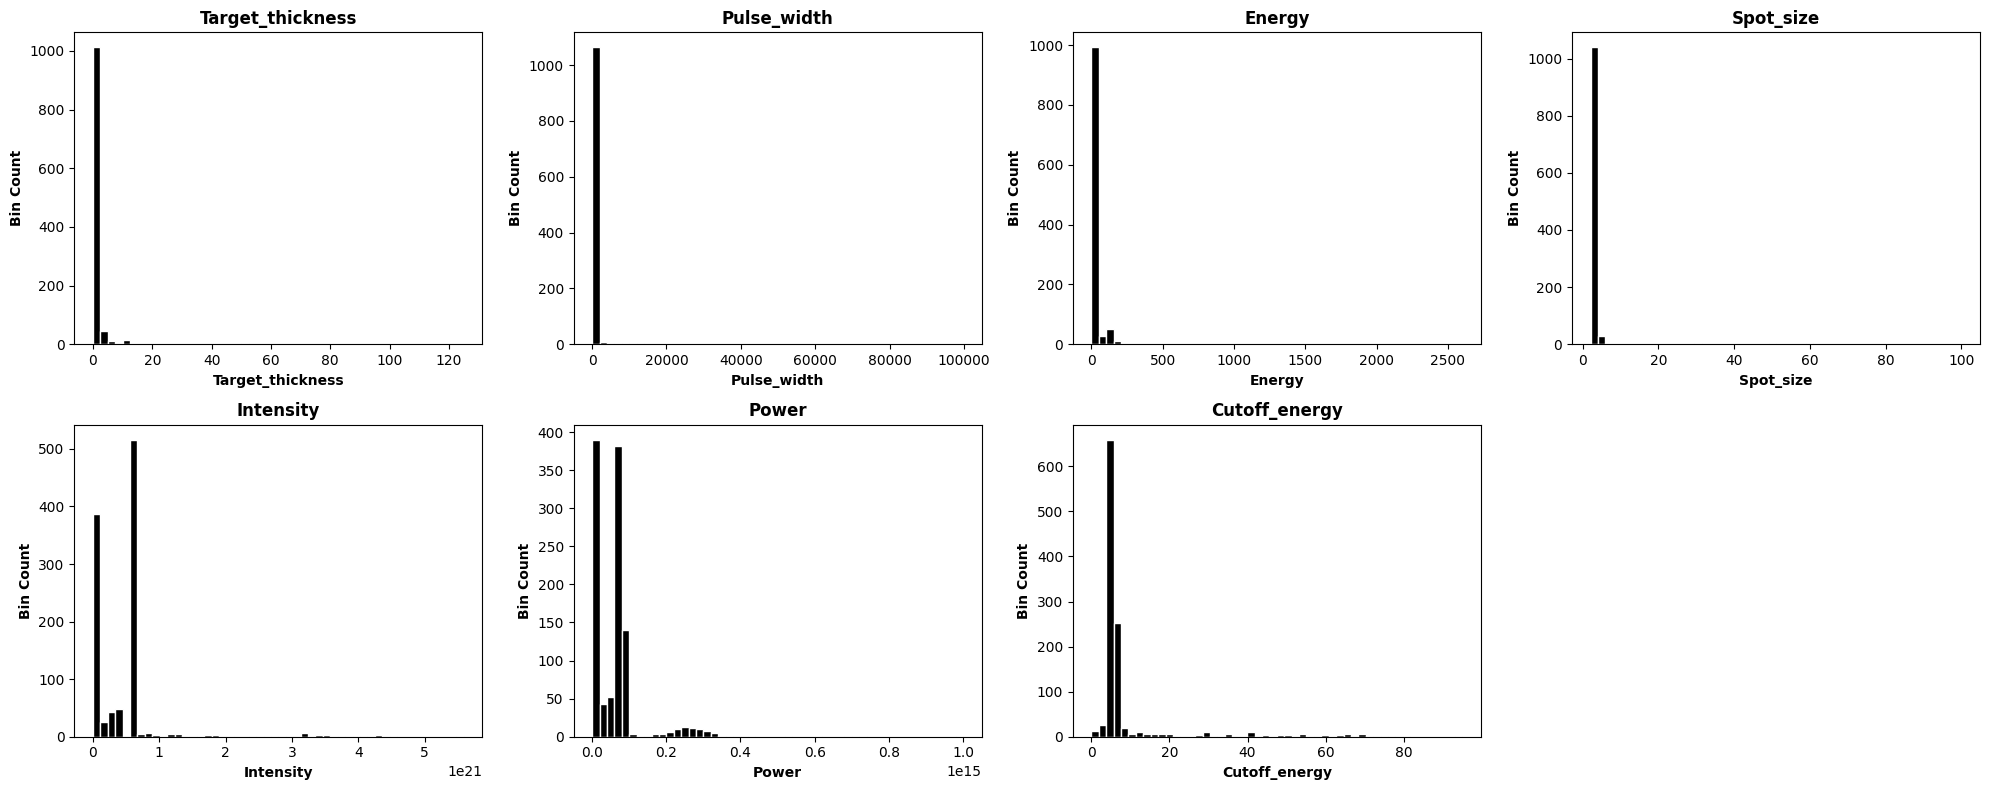

In [8]:
# Create a 4x2 grid of subplots (7 subplots, with 1 left empty)
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 8))
axes = axes.flatten()

# Iterate over numeric columns and their corresponding subplot
for i, col in enumerate(numeric_features):
    ax = axes[i]
    counts, bin_edges, patches = ax.hist(df[col], bins=50, color='black', edgecolor='white', label=col.capitalize())
    
    ax.set_title(col.capitalize(), fontweight='bold')
    ax.set_ylabel('Bin Count', fontweight='bold')
    ax.set_xlabel(col.capitalize(), fontweight='bold')

    # Display minor grid lines
    ax.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')

# Remove any unused subplot (in case of an empty grid cell)
for j in range(len(numeric_features), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout for better spacing
plt.tight_layout()
plt.savefig('eda_feature_histogram.jpg')
plt.show()

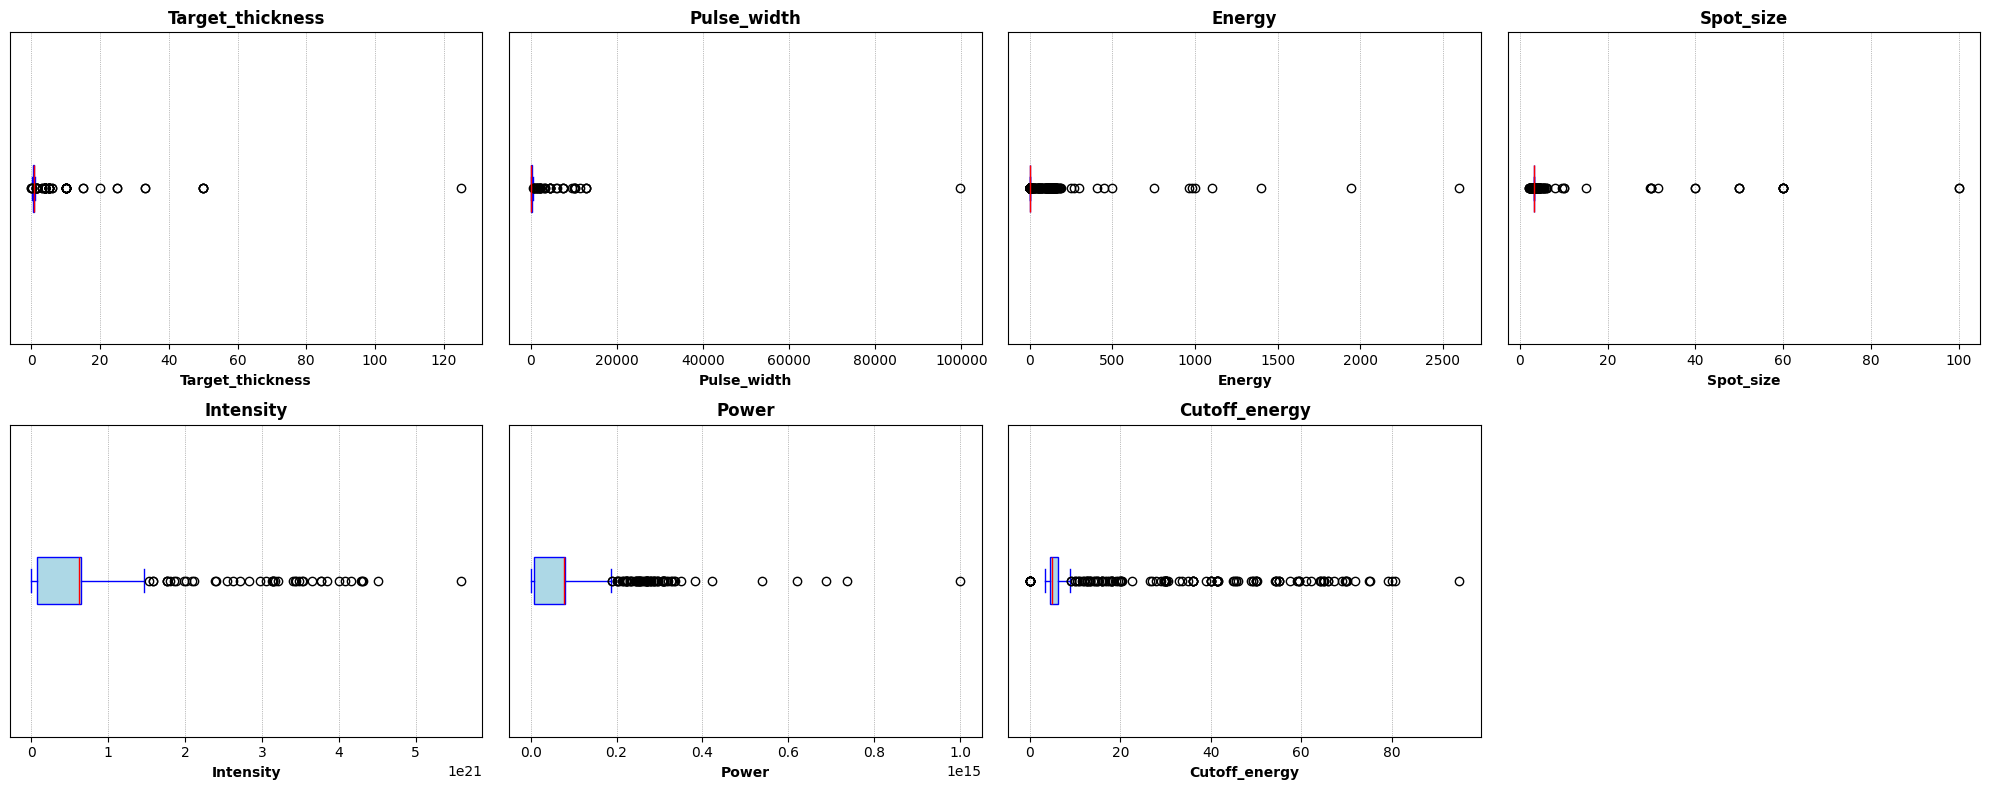

In [9]:

# Create a 4x2 grid of subplots (7 subplots, with 1 left empty)
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 8))
axes = axes.flatten()

# Iterate over numeric columns and their corresponding subplot
for i, col in enumerate(numeric_features):
    ax = axes[i]

    # Create boxplot for each numeric column
    ax.boxplot(df[col], vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue', color='blue'), whiskerprops=dict(color='blue'), capprops=dict(color='blue'), medianprops=dict(color='red'))

    # Remove the default y-tick labels
    ax.set_yticks([])
    
    # Set titles and labels
    ax.set_title(col.capitalize(), fontweight='bold')
    ax.set_xlabel(col.capitalize(), fontweight='bold')

    # Display minor grid lines
    ax.grid(which='both', linestyle=':', linewidth='0.5', color='gray')

# Remove any unused subplot (in case of an empty grid cell)
for j in range(len(numeric_features), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout for better spacing
plt.tight_layout()
plt.savefig('eda_feature_boxplot.jpg')
plt.show()

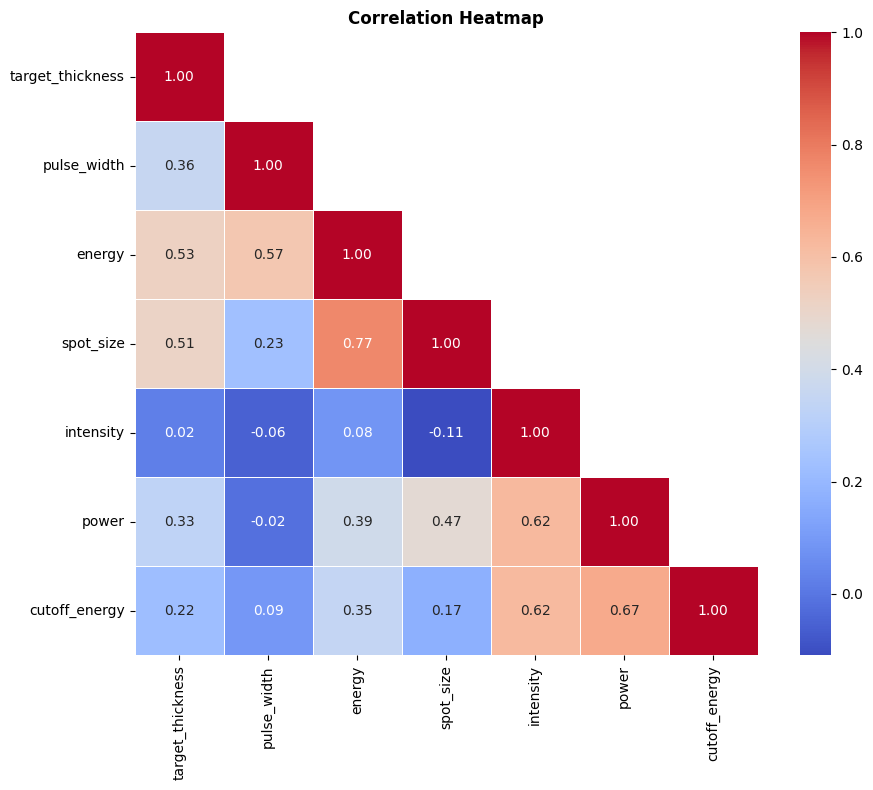

In [10]:
# Compute the correlation matrix for the specified numeric columns
corr_matrix = df[numeric_features].corr()

# Create a mask for the upper triangle excluding the diagonal
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)

# Create the correlation heatmap with the upper triangle masked
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5, square=True)

# Set the title
plt.title('Correlation Heatmap', fontweight='bold')

# Display the heatmap
plt.tight_layout()
plt.savefig('eda_feature_corr_heatmap.jpg')
plt.show()

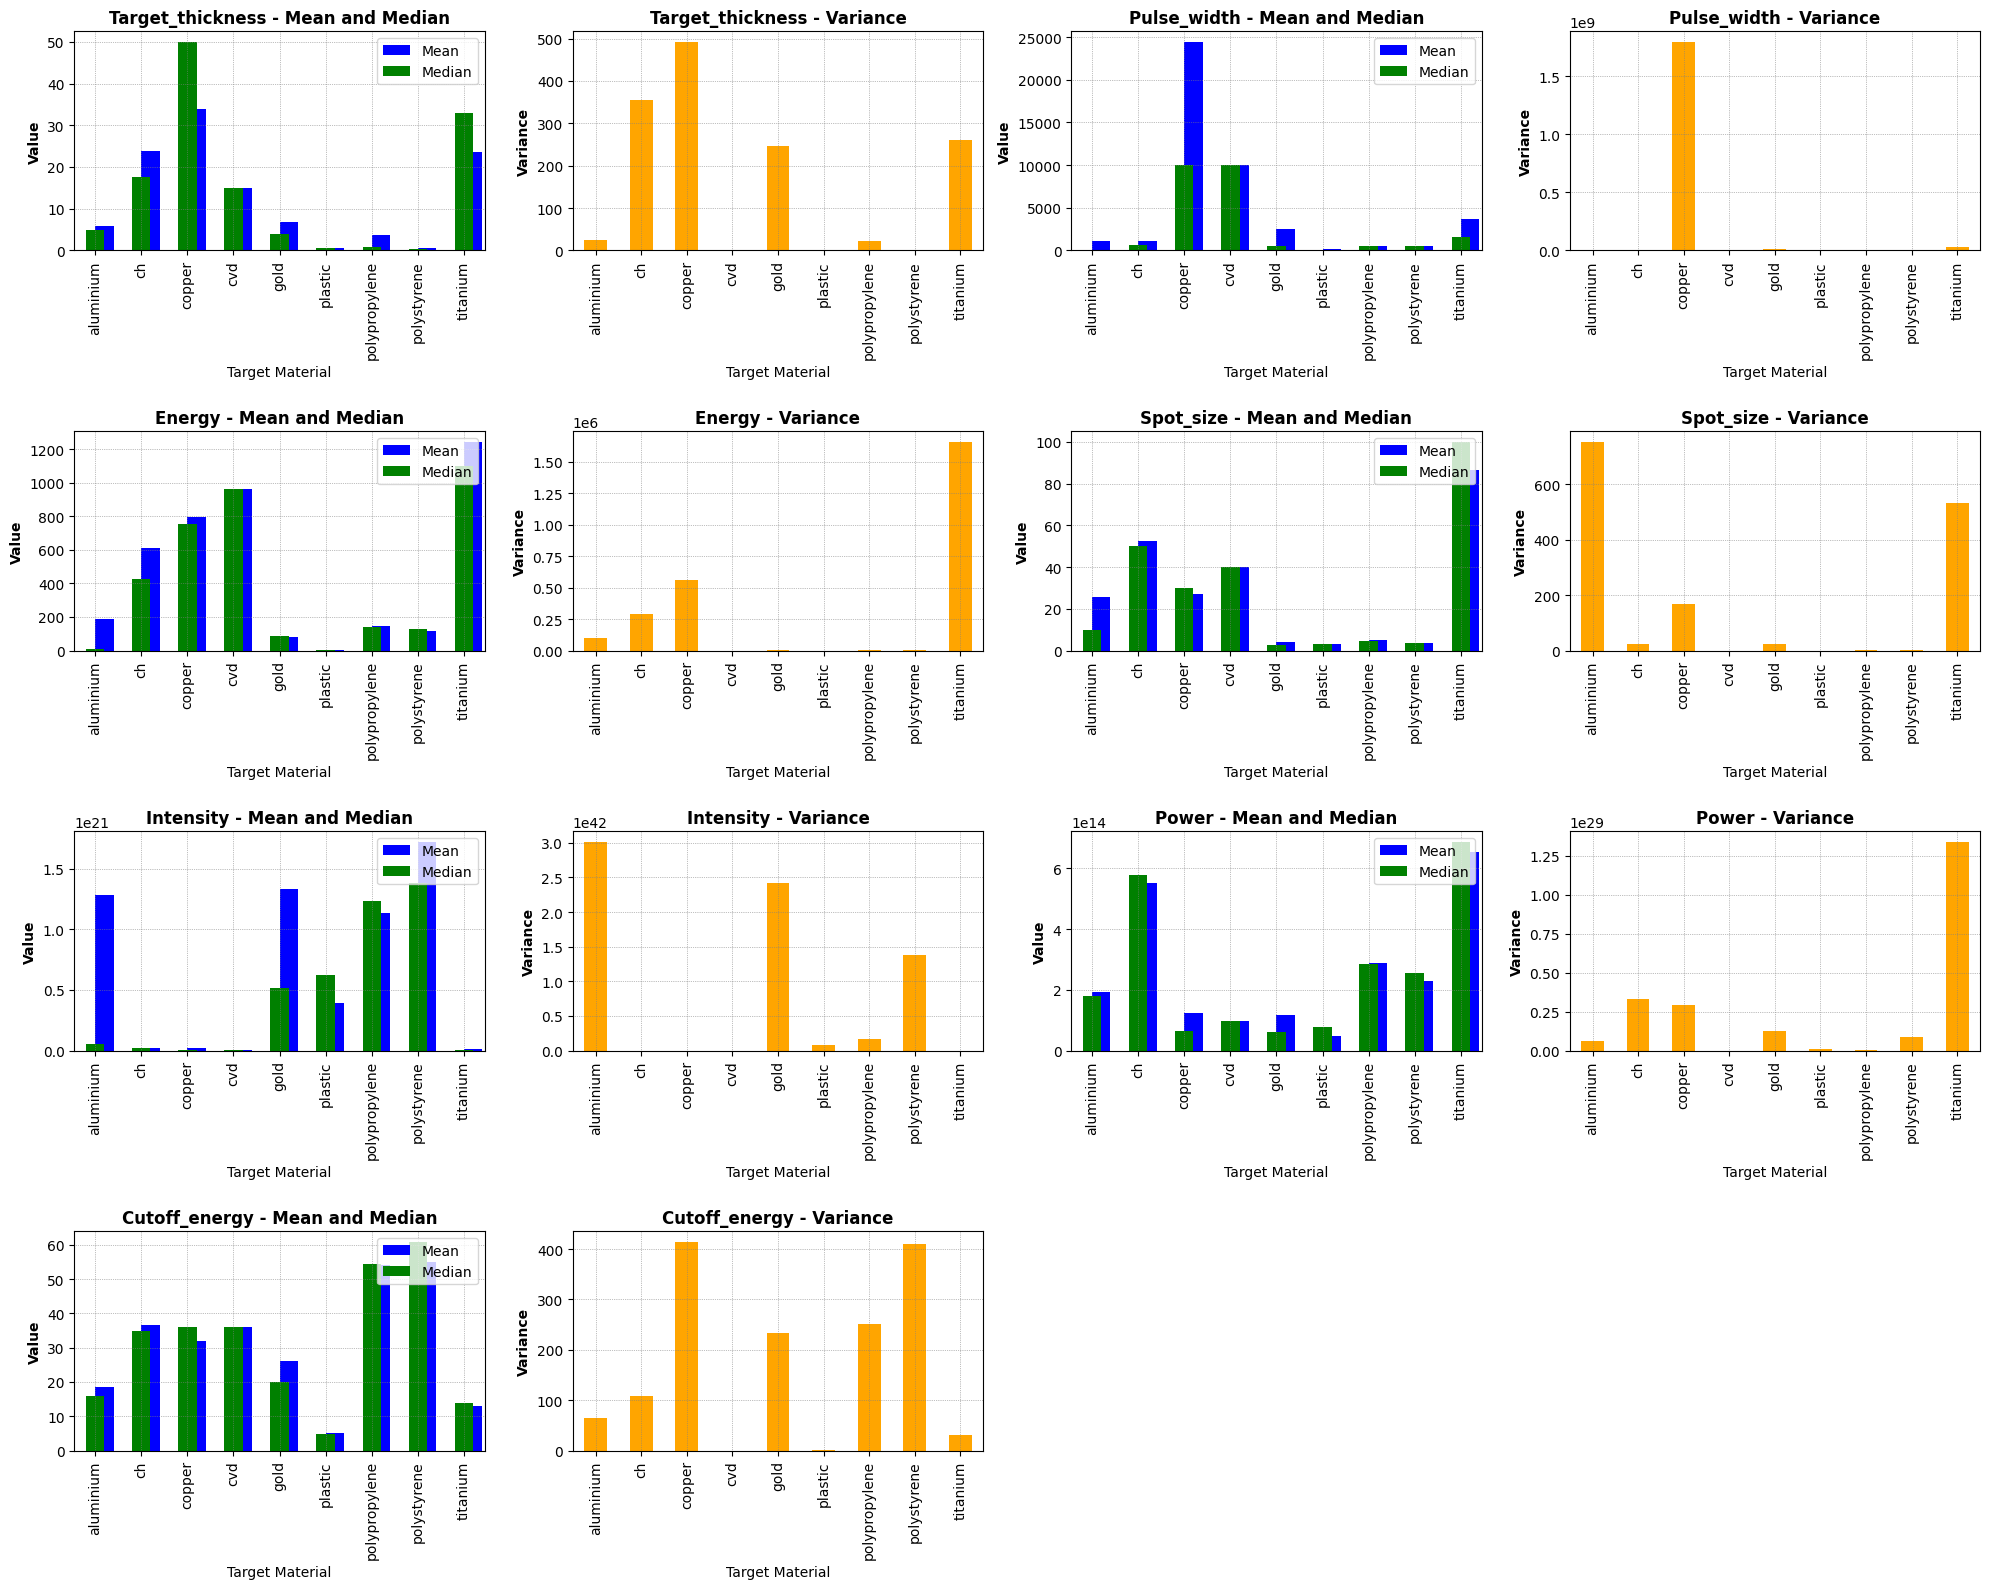

In [11]:
import math

# Calculate mean, median, and variance grouped by `target_material`
tm_means = df.groupby('target_material').mean()
tm_medians = df.groupby('target_material').median()
tm_var = df.groupby('target_material').var()

# List of numeric columns
numeric_col = tm_means.columns.tolist()
num_features = len(numeric_col)

# Number of columns and rows (4 columns: two for each feature)
num_cols = 4
num_rows = math.ceil(num_features / 2)  # Two features per row, with one column for each plot type

# Create a grid of subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, num_rows * 4))
axes = axes.flatten()  # Flatten to a 1D array for easier indexing

# Plot mean-median and variance subplots in adjacent columns
for i, col in enumerate(numeric_col):
    ax_mean_median = axes[i * 2]
    ax_variance = axes[i * 2 + 1]

    # Plot the combined Mean-Median chart
    tm_means[col].plot(kind='bar', ax=ax_mean_median, position=0, width=0.4, color='blue', label='Mean', align='center')
    tm_medians[col].plot(kind='bar', ax=ax_mean_median, position=1, width=0.4, color='green', label='Median', align='edge')

    ax_mean_median.set_title(f'{col.capitalize()} - Mean and Median', fontweight='bold')
    ax_mean_median.set_ylabel('Value', fontweight='bold')
    ax_mean_median.set_xlabel('Target Material')
    ax_mean_median.legend(loc='upper right')
    ax_mean_median.grid(which='both', linestyle=':', linewidth='0.5', color='gray')

    # Plot the variance chart
    tm_var[col].plot(kind='bar', ax=ax_variance, color='orange')
    ax_variance.set_title(label=f'{col.capitalize()} - Variance',fontweight='bold')
    ax_variance.set_ylabel('Variance', fontweight='bold')
    ax_variance.set_xlabel('Target Material')
    ax_variance.grid(which='both', linestyle=':', linewidth='0.5', color='gray')

# Remove unused subplots (if any)
for j in range(i * 2 + 2, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout for better spacing
plt.tight_layout()
plt.savefig('eda_feature_mean_median_variance.jpg')
plt.show()

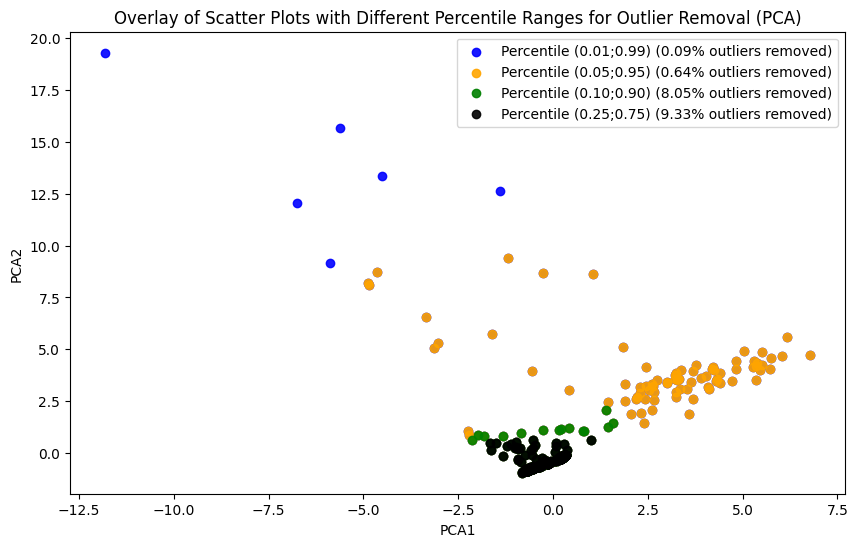

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Assuming df and numerical_features are already defined
pctl_range = [
    #1, 
    2, 
    #5, 
    10, 
    20, 
    50
]
colors = ['blue', 'orange', 'green', 'black']

# Define the new labels for the legend
percentile_labels = [
    '(0.01;0.99)', 
    '(0.05;0.95)', 
    '(0.10;0.90)', 
    '(0.25;0.75)'
]

# Normalize the numerical features
scaler = StandardScaler()
df_normal = pd.DataFrame(scaler.fit_transform(df[numeric_features]), columns=numeric_features)

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_normal)
df_pca = pd.DataFrame(data=pca_result, columns=['PCA1', 'PCA2'])

plt.figure(figsize=(10, 6))

for i, num_pcntl in enumerate(pctl_range):
    right_tail = round((100 - (num_pcntl / 2)) / 100, 3)
    left_tail = round(1 - right_tail, 3)

    col1 = 'PCA1'
    col2 = 'PCA2'
    
    # Calculate Q1 (left_tail) and Q3 (right_tail) of the PCA components
    Q1 = df_pca[[col1,col2]].quantile(left_tail)
    Q3 = df_pca[[col1,col2]].quantile(right_tail)
    IQR = Q3 - Q1
    
    # Create a boolean mask where True indicates an outlier
    outlier_mask = ((df_pca[[col1,col2]] < (Q1 - 1.5 * IQR)) | (df_pca[[col1,col2]] > (Q3 + 1.5 * IQR)))
    
    num_outliers = outlier_mask.any(axis=1).sum()
    total = len(df_pca)
    outlier_percent = num_outliers / total * 100
    
    # Plotting non-outliers
    plt.scatter(df_pca.loc[~outlier_mask.any(axis=1), col2], 
                df_pca.loc[~outlier_mask.any(axis=1), col1], 
                color=colors[i], alpha=0.9, 
                label=f'Percentile {percentile_labels[i]} ({outlier_percent:.2f}% outliers removed)')
    
plt.title('Overlay of Scatter Plots with Different Percentile Ranges for Outlier Removal (PCA)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend()
plt.savefig('eda_effect_of_outlier_removal_pca.jpg')
plt.show()

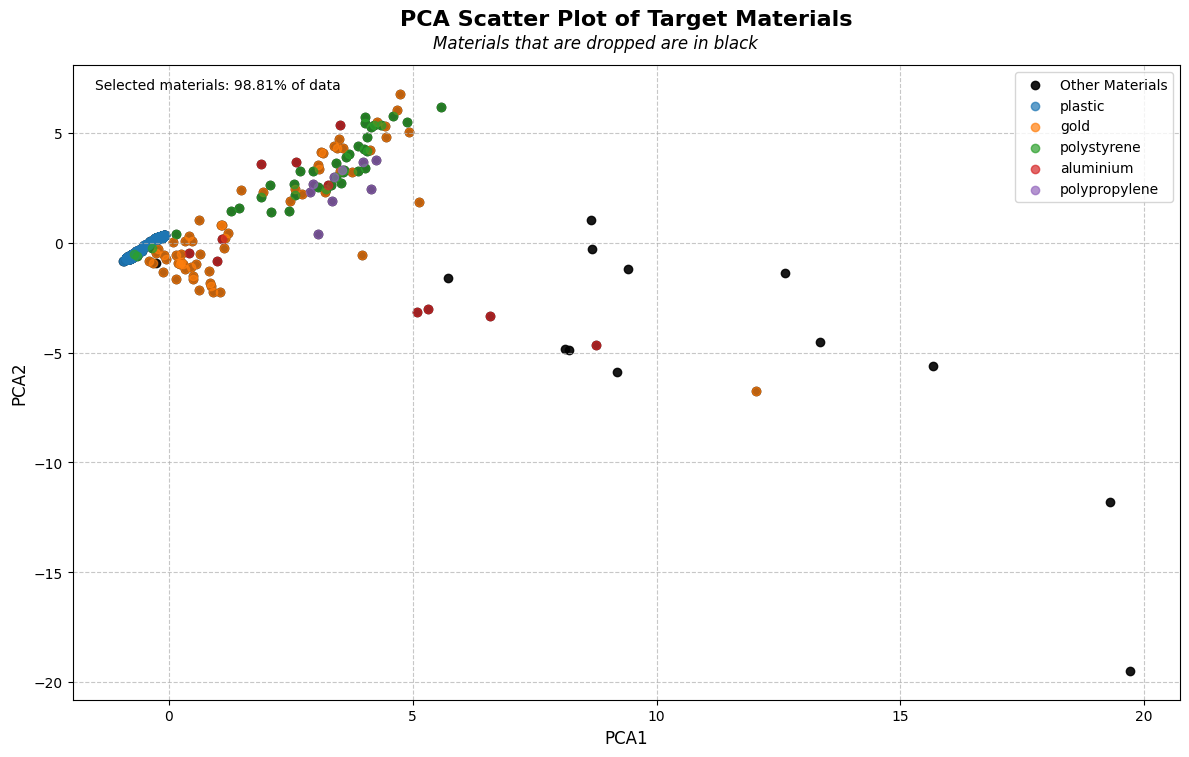

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Assuming df and numeric_features are already defined
target_material_keep = ['plastic', 'gold', 'polystyrene', 'aluminium', 'polypropylene']

# Normalize the numerical features
scaler = StandardScaler()
df_normal = pd.DataFrame(scaler.fit_transform(df[numeric_features]), columns=numeric_features)

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_normal)
df_pca = pd.DataFrame(data=pca_result, columns=['PCA1', 'PCA2'])

# Add the target_material column to df_pca
df_pca['target_material'] = df['target_material']

# Create a mask for the selected materials
selected_mask = df_pca['target_material'].isin(target_material_keep)

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Plot all data points
ax.scatter(df_pca['PCA1'], df_pca['PCA2'], 
           color='black', alpha=0.9, label='Other Materials')

# Plot selected materials
for material in target_material_keep:
    material_mask = df_pca['target_material'] == material
    ax.scatter(df_pca.loc[material_mask, 'PCA1'], 
               df_pca.loc[material_mask, 'PCA2'], 
               alpha=0.7, label=material)

# Set title and subtitle
ax.set_title('PCA Scatter Plot of Target Materials', fontweight='bold', fontsize=16, y=1.05)
fig.suptitle('Materials that are dropped are in black', fontsize=12, fontstyle='italic', y=0.91)

ax.set_xlabel('PCA1', fontsize=12)
ax.set_ylabel('PCA2', fontsize=12)
ax.legend(fontsize=10)
ax.grid(True, linestyle='--', alpha=0.7)

# Add text annotations for percentage of data points
total_points = len(df_pca)
selected_points = selected_mask.sum()
selected_percentage = (selected_points / total_points) * 100

ax.text(0.02, 0.98, f'Selected materials: {selected_percentage:.2f}% of data', 
        transform=ax.transAxes, verticalalignment='top', fontsize=10)

plt.tight_layout()
plt.savefig('eda_drop_material_pca.jpg')
plt.show()

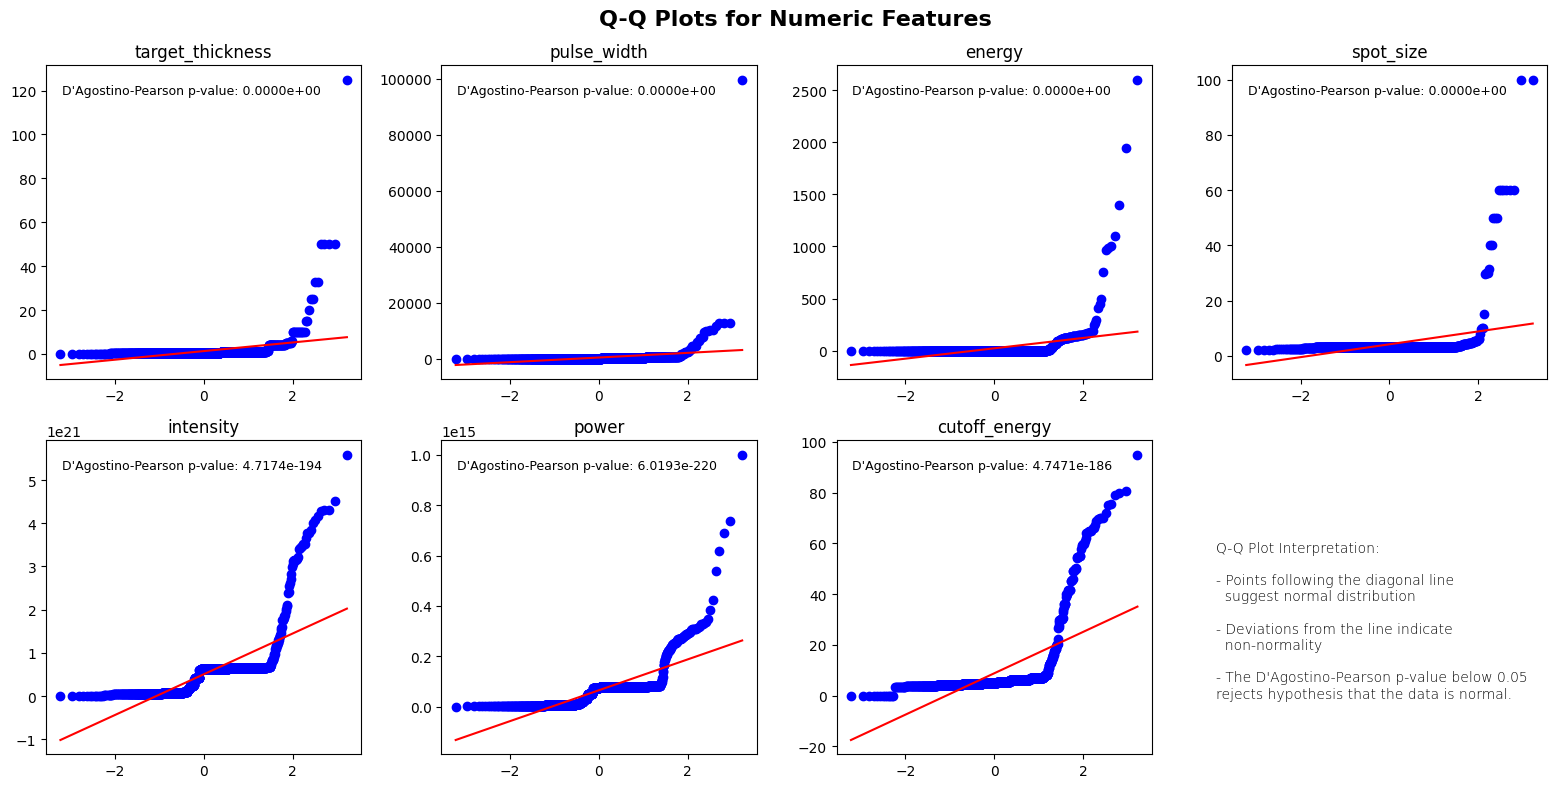

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Assuming df and numeric_features are already defined

def plot_qq_subplots(data, features):
    n_features = len(features)
    rows = (n_features + 1) // 4  # Round up to nearest integer
    cols = 4
    
    fig, axes = plt.subplots(rows, cols, figsize=(16, 4*rows))
    fig.suptitle("Q-Q Plots for Numeric Features", fontsize=16,weight='bold')
    
    for i, feature in enumerate(features):
        ax = axes[i // cols, i % cols]
        stats.probplot(data[feature], dist="norm", plot=ax)
        ax.set_title(f"{feature}")
        ax.set_ylabel('')
        ax.set_xlabel('')
        
        # Calculate p-value
        _, p_value = stats.normaltest(data[feature])
        
        # Add text with p-value
        ax.text(0.05, 0.90, f"D'Agostino-Pearson p-value: {p_value:.4e}", 
                transform=ax.transAxes, fontsize=9, verticalalignment='bottom')
    
    # Add general info in the last subplot
    last_ax = axes[-1, -1]
    last_ax.axis('off')
    info_text = "Q-Q Plot Interpretation:\n\n"
    info_text += "- Points following the diagonal line\n  suggest normal distribution\n\n"
    info_text += "- Deviations from the line indicate\n  non-normality\n\n"
    info_text += "- The D'Agostino-Pearson p-value below 0.05 \nrejects hypothesis that the data is normal."
    last_ax.text(-0.05, 0.68, info_text, fontsize=10, va='top', weight='light')

    plt.tight_layout()
    plt.savefig('eda_qq_plot.jpg', dpi=300, bbox_inches='tight')
    plt.show()

def test_normality(data, features):
    results = {}
    for feature in features:
        _, p_value = stats.normaltest(data[feature])
        results[feature] = p_value
    return results

# Plot Q-Q plots
plot_qq_subplots(df, numeric_features)

In [15]:
import pandas as pd
import numpy as np
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.formula.api import ols

def test_heteroscedasticity(data, features):
    results = []
    for feature in features:
        # Create a model where all other features predict the current feature
        predictors = '+'.join([f for f in features if f != feature])
        formula = f"{feature} ~ {predictors}"
        model = ols(formula, data=data).fit()
        
        # Perform Breusch-Pagan test
        _, p_value, _, _ = het_breuschpagan(model.resid, model.model.exog)
        
        # Determine description based on p-value
        description = "Evidence of heteroscedasticity" if p_value < 0.05 else "No strong evidence"
        
        # Append results to list
        results.append({
            'Feature': feature,
            'p-value': p_value,
            'Description': description
        })
    
    return pd.DataFrame(results)

# Use the function
heteroscedasticity_results = test_heteroscedasticity(df, numeric_features)

# Sort the results by p-value
heteroscedasticity_results = heteroscedasticity_results.sort_values('p-value')

# Print the DataFrame
print("Heteroscedasticity Test Results (Breusch-Pagan test):")
print(heteroscedasticity_results.to_string(index=False))

# Save to CSV
heteroscedasticity_results.to_csv('heteroscedasticity_results.csv', index=False)

# If you want to format p-values to 4 decimal places in the CSV:
heteroscedasticity_results['p-value'] = heteroscedasticity_results['p-value'].apply(lambda x: f"{x:.4f}")
heteroscedasticity_results.to_csv('eda_heteroscedasticity_results_formatted.csv', index=False)

Heteroscedasticity Test Results (Breusch-Pagan test):
         Feature       p-value                    Description
       intensity 1.684976e-103 Evidence of heteroscedasticity
   cutoff_energy  1.448471e-82 Evidence of heteroscedasticity
       spot_size  2.879041e-29 Evidence of heteroscedasticity
          energy  8.753128e-09 Evidence of heteroscedasticity
target_thickness  6.499387e-06 Evidence of heteroscedasticity
     pulse_width  1.000000e+00             No strong evidence
           power  1.000000e+00             No strong evidence
